In [1]:
from IPython.display import clear_output
!pip install paddle-quantum==2.3.0
!pip install qiskit
# !pip install qiskit-experiments
clear_output()

In [2]:
import qiskit.tools.jupyter
%qiskit_version_table

In [3]:
import qiskit
from qiskit.circuit.parameterexpression import ParameterValueType
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import pulse, QuantumCircuit, IBMQ, visualization,execute, Aer
from qiskit.pulse import library
from qiskit.visualization.pulse_v2.stylesheet import IQXDebugging
from qiskit.visualization.pulse_v2 import draw
from qiskit.providers.fake_provider import *
from qiskit.pulse import transforms
from qiskit.pulse.transforms import block_to_schedule
from qiskit.pulse import filters
from qiskit.pulse.filters import composite_filter, filter_instructions
from typing import List, Tuple, Iterable, Union, Dict, Callable, Set, Optional, Any
from qiskit.pulse.instructions import Instruction
from qiskit.compiler import assemble, schedule
import numpy as np

In [4]:

import qiskit
from qiskit.circuit.library import TwoLocal, RealAmplitudes
from qiskit import pulse, QuantumCircuit,circuit
from qiskit.circuit import Gate
from qiskit.pulse import library, Schedule,GaussianSquare, ControlChannel, Play, Drag,DriveChannel,Delay,DriveChannel, SymbolicPulse, ShiftPhase
from qiskit.pulse import transforms
from qiskit.pulse.transforms import block_to_schedule,remove_directives
from qiskit.pulse import filters
from qiskit.pulse.filters import composite_filter, filter_instructions
from typing import List, Tuple, Iterable, Union, Dict, Callable, Set, Optional, Any
from qiskit.tools.visualization import circuit_drawer
from qiskit.visualization.pulse_v2 import draw, IQXSimple,IQXDebugging
from qiskit.compiler import assemble, schedule
from qiskit import IBMQ


In [ ]:
IBMQ.save_account('c7a71bc4b2858304571d35eb5e371e449e5c346110b36c744f51b65388d4ac1b7468740d58d6fcd44967b2080d02af986cc22f2406a84813bbabd9ff5bf06315', overwrite=True)
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers
provider = IBMQ.get_provider(
    hub="ibm-q-ornl", group="ornl", project="csc509"
)
# backend = provider.get_backend('ibmq_guadalupe')

ibmqfactory.load_account:WARNING:2023-03-04 23:32:39,537: Credentials are already in use. The existing account in the session will be replaced.


In [5]:
backend = FakeQuito()
# backend = FakeArmonk()

In [ ]:
with pulse.build(backend) as pulse_prog1:
  circ = QuantumCircuit(1)
  circ.h(0)
  pulse.call(circ)

print(pulse_prog1)

ScheduleBlock(ScheduleBlock(ShiftPhase(-1.5707963268, DriveChannel(0)), ShiftPhase(-1.5707963268, ControlChannel(1)), Play(Drag(duration=160, sigma=40, beta=0.3574624189942019, amp=0.08391870647301973, angle=0.017630540123828586, name='drag_9d65'), DriveChannel(0), name='drag_9d65'), TimeBlockade(160, ControlChannel(1)), ShiftPhase(-1.5707963268, DriveChannel(0)), ShiftPhase(-1.5707963268, ControlChannel(1)), name="circuit-90", transform=AlignLeft()), name="block0", transform=AlignLeft())


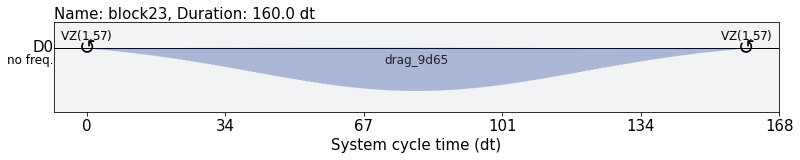

In [ ]:
pulse_prog1.draw()

In [6]:
def generate_parametric_pulse(backend, q1, amp_list, angle_list):
  backend_defaults = backend.defaults()
  inst_sched_map = backend_defaults.instruction_schedule_map 
  x_pulse = inst_sched_map.get('x', (0)).filter(channels = [DriveChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
  duration_parameter = x_pulse.parameters['duration']
  sigma_parameter = x_pulse.parameters['sigma']
  beta_parameter = x_pulse.parameters['beta']
  sched1 = pulse.Play(Drag(duration=duration_parameter, sigma=sigma_parameter, beta=beta_parameter, amp=amp_list, angle=angle_list), DriveChannel(0))
  with pulse.build(backend) as pulse_x:
    with pulse.transpiler_settings(initial_layout= [0]):
      sched = Schedule()
      pulse.call(sched)
  pulse_x.append(sched1)
  with pulse.build(backend) as pulse_y:
    with pulse.transpiler_settings(initial_layout= [0]): 
      pulse.call(pulse_x)
      pulse.barrier(q1)
      pulse.measure(q1)

  return  block_to_schedule(pulse_y)

In [7]:
def generate_parametric_pulse_h(backend, q1, amp_list, angle_list):
  sched1 = pulse.Play(Drag(duration=160, sigma=40, beta=0.4469017066717889, amp=amp_list, angle=angle_list), DriveChannel(0))
  with pulse.build(backend) as pulse_h:
    with pulse.transpiler_settings(initial_layout= [0]):
      circ = QuantumCircuit(1)
      circ.h(0)
      pulse.call(circ)
  # pulse_h.append(sched1)
  pulse_h.append(sched1)
  with pulse.build(backend) as pulse_h2:
    with pulse.transpiler_settings(initial_layout= [0]):
      pulse.call(pulse_h) 
      pulse.barrier(q1)
      pulse.measure(q1)

  return  block_to_schedule(pulse_h2)

In [8]:
def generate_parametric_pulse_xmeasure(backend, q1, amp_list, angle_list):
  sched1 = pulse.Play(Drag(duration=160, sigma=40, beta=0.4469017066717889, amp=amp_list, angle=angle_list), DriveChannel(0))
  with pulse.build(backend) as pulse_x:
    with pulse.transpiler_settings(initial_layout= [0]):
      sched = Schedule()
      pulse.call(sched)
  pulse_x.append(sched1)
  with pulse.build(backend) as pulse_y:
    with pulse.transpiler_settings(initial_layout= [0]):
      pulse.call(pulse_x)
  with pulse.build(backend) as pulse_y1:
    with pulse.transpiler_settings(initial_layout= [0]):
      circ = QuantumCircuit(1)
      circ.h(0)
      pulse.call(circ)
  pulse_y.append(pulse_y1)
  with pulse.build(backend) as pulse_y2:
    with pulse.transpiler_settings(initial_layout= [0]):
      pulse.call(pulse_y) 
      pulse.barrier(q1)
      pulse.measure(q1)

  return  block_to_schedule(pulse_y2)

## Test case

In [ ]:
backend

<FakeQuito('fake_quito')>

In [9]:
pulse_x = generate_parametric_pulse(backend, 0, 0.5, 0)

In [10]:
import qiskit.quantum_info as qi


backend.configuration().hamiltonian['qub'] = {'0': 2,'1': 2,'2': 2,'3': 2,'4': 2 }
job=execute(pulse_x, backend, shots=100000, meas_level=2, meas_return='avg')
results = job.result()
vec = results.get_statevector()
# print(vec)
rho = qi.partial_trace(vec, [1,2,3,4])

# rho = np.array([vec]).T.conj()@np.array([vec])

print(rho)
# print(rho.data)
print("\n Check purity if it's a pure state:", qi.purity(rho))

/usr/local/lib/python3.9/dist-packages/qiskit_aer/pulse/controllers/pulse_controller.py:144: UserWarning: Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, so it is being automatically determined from the drift Hamiltonian.
  warn('Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, '


DensityMatrix([[0.33426443+0.j        , 0.1360067 +0.45166546j],
               [0.1360067 -0.45166546j, 0.66573557+0.j        ]],
              dims=(2,))

 Check purity if it's a pure state: (0.9999355847190134+0j)


In [ ]:
pulse_x = generate_parametric_pulse_h(backend, 0, 0.1, np.pi)
job=execute(pulse_x, backend, shots=10000, meas_level=2, meas_return='avg')
results = job.result()
vec = results.get_statevector()
rho = qi.partial_trace(vec, [1,2,3,4])
# print(rho)
print(rho.data)

[[0.54314049+0.j         0.37350207-0.32957416j]
 [0.37350207+0.32957416j 0.45685951+0.j        ]]


In [ ]:
job = execute(pulse_x, backend, shots = 10000)
results = job.result()
counts = results.get_counts()
print(counts)

{'0': 5428, '1': 4572}


## Bloch Sphere Visualization

In [11]:
import numpy as np
import paddle
import paddle_quantum as pq
from paddle_quantum.ansatz.circuit import Circuit
from paddle_quantum.visual import plot_state_in_bloch_sphere

/usr/local/lib/python3.9/dist-packages/openfermion/hamiltonians/hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
/usr/local/lib/python3.9/dist-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


In [12]:
import random
import decimal

amp_min = 0
amp_max = 1
outputs_amp = list()   
# amp = np.linspace(amp_min, amp_max, 100)
num_sample = 5000
amp_list = []


for _ in range(num_sample):

  amp = decimal.Decimal(random.randrange(0, 100000))/100000

  # generate new parametrized pulse
  pulse_x = generate_parametric_pulse(backend, 0, amp, 0)

  # set up pulse schedule
  job = execute(pulse_x, backend, shots=2048, meas_level=2, meas_return='avg')
  results = job.result()

  # Returen the density matrix of q0
  vec = results.get_statevector()
  rho = qi.partial_trace(vec, [1,2,3,4])
  # rho = np.array([vec]).T.conj()@np.array([vec])

  # record data
  outputs_amp.append(rho.data)
  amp_list.append(amp)

/usr/local/lib/python3.9/dist-packages/qiskit/providers/fake_provider/fake_backend.py:552: DeprecationWarning: The Pulse simulator backend in Qiskit Aer is deprecated and will be removed in a future release. Instead the qiskit-dynamics library should be used instead for simulating at the pulse level.
  sim = aer.Aer.get_backend("pulse_simulator")
/usr/local/lib/python3.9/dist-packages/qiskit_aer/aerprovider.py:86: DeprecationWarning: The Pulse simulator backend in Qiskit Aer is deprecated and will be removed in a future release. Instead the qiskit-dynamics library should be used instead for simulating at the pulse level.
  backends.append(backend_cls(**opts))
/usr/local/lib/python3.9/dist-packages/qiskit_aer/pulse/controllers/pulse_controller.py:144: UserWarning: Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, so it is being automatically determined from the drift Hamiltonian.
  warn('Warning: qubit_lo_freq was not specified in PulseQobj and there is no d

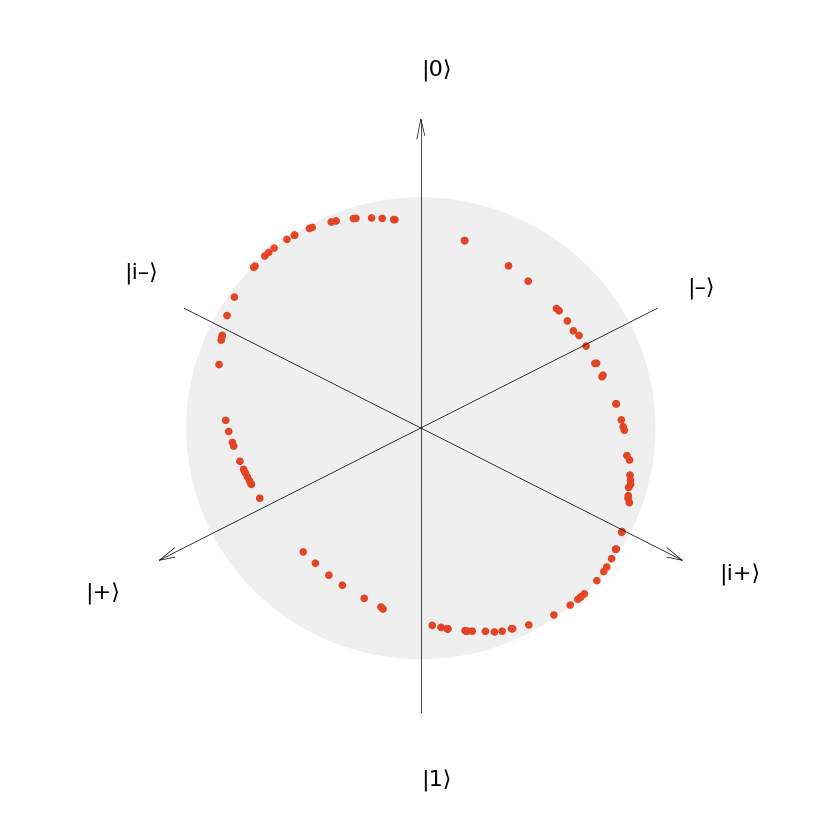

In [ ]:
plot_state_in_bloch_sphere(outputs_amp, save_gif=True, filename='figures/quito_bloch_amp_0angle.gif')

In [13]:
angle_min = 0
angle_max = 2*np.pi
angle_list = []
outputs_angle = list()   
# angle = np.linspace(angle_min, angle_max, 100)
num_sample = 5000
angle_list = []


for _ in range(num_sample):

  rand_num = decimal.Decimal(random.randrange(0, 100000))/100000
  ang = 2*np.pi*float(rand_num)

  # generate new parametrized pulse
  pulse_x = generate_parametric_pulse(backend, 0, 0.08, ang)
  # set up pulse schedule
  job = execute(pulse_x, backend, shots=2048, meas_level=2, meas_return='avg')
  results = job.result()

  # Returen the density matrix of q0
  vec = results.get_statevector()
  rho = qi.partial_trace(vec, [1,2,3,4])

  # record data
  outputs_angle.append(rho.data)
  angle_list.append(ang)

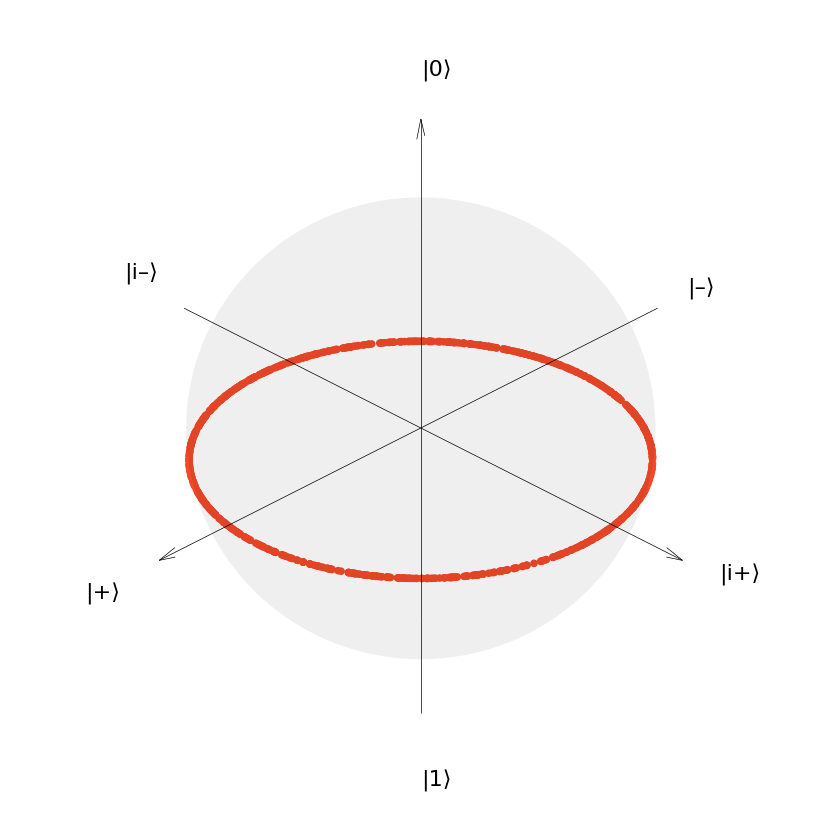

In [ ]:
plot_state_in_bloch_sphere(outputs_angle, save_gif=True, filename='figures/bloch_angle.gif')

In [14]:
outputs_mix = list()   
angle_mix_list = []
amp_mix_list = []

for _ in range(71):
  for _ in range(71):

    rand_num1 = decimal.Decimal(random.randrange(0, 100000))/100000
    ang = 2*np.pi*float(rand_num1)
    amp = decimal.Decimal(random.randrange(0, 40000))/100000

    # generate new parametrized pulse
    pulse_x = generate_parametric_pulse(backend, 0, amp, ang)

    # set up pulse schedule
    job = execute(pulse_x, backend, shots=2048, meas_level=2, meas_return='avg')
    results = job.result()

    # Returen the density matrix of q0
    vec = results.get_statevector()
    rho = qi.partial_trace(vec, [1,2,3,4])

    # record data
    outputs_mix.append(rho.data)
    angle_mix_list.append(ang)
    amp_mix_list.append(amp)

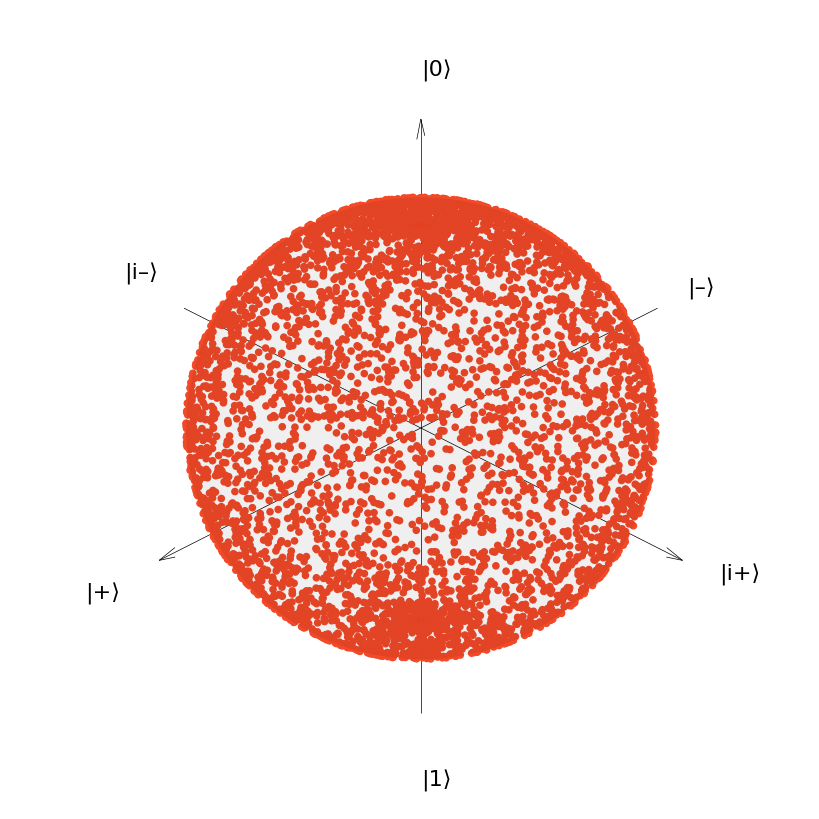

In [15]:
plot_state_in_bloch_sphere(outputs_mix, save_gif = True, filename='figures/quito_bloch_pulse.gif')



---



## Parameter Transfer

This section is aiming to explore the functional relation between gate level parameters and pulse level parameters. Espeically,

$$
R_x(\phi) \rightarrow U(A_0, \theta=0)
$$

And

$$
R_z(\lambda) \rightarrow U(A_0=0.1, \theta)
$$

In [ ]:
# amp_min = 0
# amp_max = 0.4
# outputs_amp = list()   
# amp = np.linspace(amp_min, amp_max, 100)

# for x in amp:
#   # generate new parametrized pulse
#   pulse_x = generate_parametric_pulse(backend, 0, x, 0)

#   # set up pulse schedule
#   job = execute(pulse_x, backend, shots=2048, meas_level=2, meas_return='avg')
#   results = job.result()

#   # Returen the density matrix of q0
#   vec = results.get_statevector()
#   rho = qi.partial_trace(vec, [1,2,3,4])

#   # record data
#   outputs_amp.append(rho.data)

## Haar distribution and K-L divergence

In [24]:
num_qubit = 1     # the number of qubit
num_sample = 5000    # the number of sample
outputs_z = list()   # save QNN outputs
outputs_zyz = list()

for _ in range(num_sample):
    # initialize QNN ansatz
    pq.set_backend('density_matrix')
    cir = Circuit(num_qubit)
    # apply Rz with a random rotating angle
    cir.rz(0)
    # output a density operator
    rho = cir(pq.state.zero_state(num_qubit))
    outputs_z.append(rho.numpy())

outputs_x = list()   # save QNN outputs
for _ in range(num_sample):
    # initialize QNN ansatz
    cir = Circuit(num_qubit)
    # apply Rx with random rotating angles
    cir.rx(0)
    # output a density operator
    rho = cir(pq.state.zero_state(num_qubit))
    outputs_x.append(rho.numpy())

outputs_xz = list()   # save QNN outputs
for _ in range(num_sample):
    # initialize QNN ansatz
    cir = Circuit(num_qubit)
    # apply Rx and Rz with random rotating angles
    cir.rx(0)
    cir.rz(0)
    # output a density operator
    rho = cir(pq.state.zero_state(num_qubit))
    outputs_xz.append(rho.numpy())

outputs_zxz = list()   # save QNN outputs
for _ in range(num_sample):
    # initialize QNN ansatz
    cir = Circuit(num_qubit)
    # apply Rz, Rx, and Rz with random rotating angles
    cir.rz(0)
    cir.rx(0)
    cir.rz(0)
    # output a density operator
    rho = cir(pq.state.zero_state(num_qubit))
    outputs_zxz.append(rho.numpy())


outputs_zyz = list()   # save QNN outputs
for _ in range(num_sample):
    # initialize QNN ansatz
    cir = Circuit(num_qubit)
    # apply Rz, Rx, and Rz with random rotating angles
    cir.rz(0)
    cir.ry(0)
    cir.rz(0)
    # output a density operator
    rho = cir(pq.state.zero_state(num_qubit))
    outputs_zyz.append(rho.numpy())

/usr/local/lib/python3.9/dist-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:


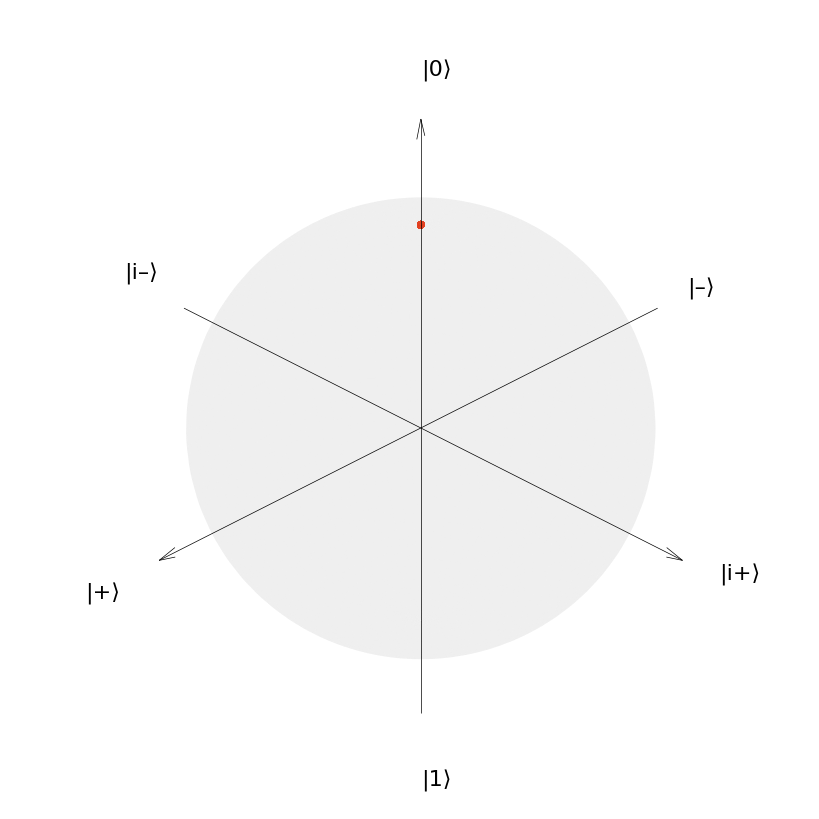

In [25]:
plot_state_in_bloch_sphere(outputs_z, save_gif=True, filename='figures/bloch_z.gif')

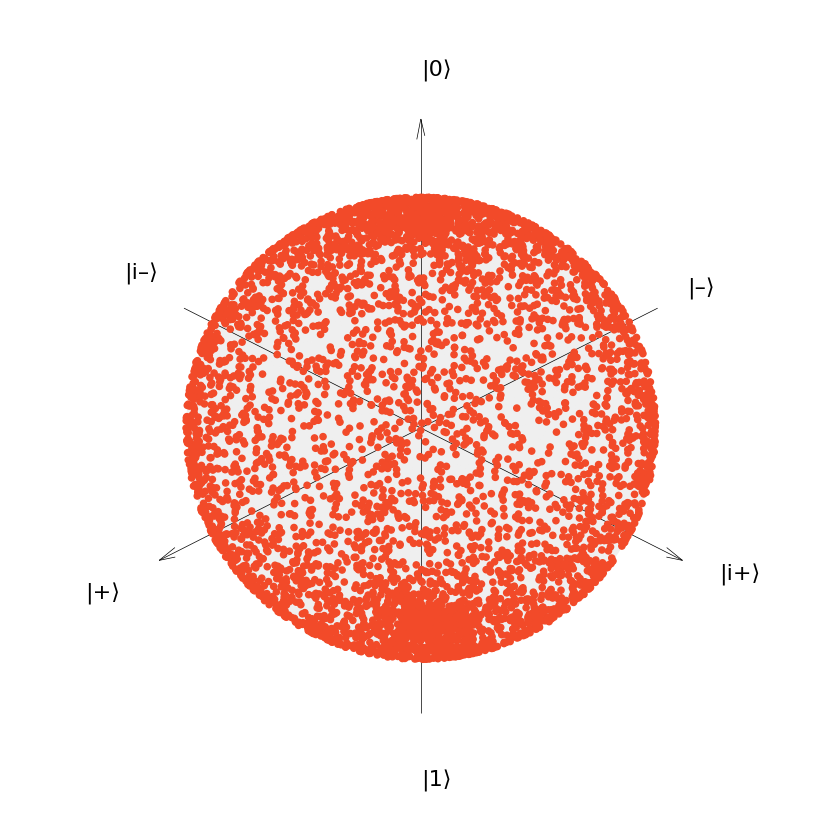

In [26]:
plot_state_in_bloch_sphere(outputs_xz, save_gif=True, filename='figures/bloch_xz.gif')

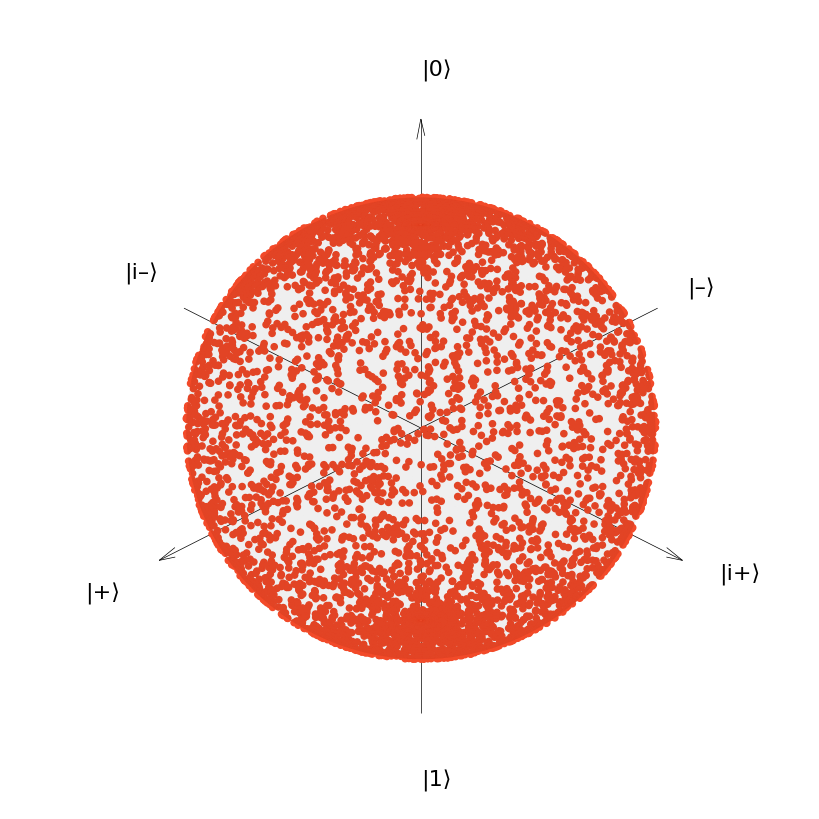

In [27]:
plot_state_in_bloch_sphere(outputs_zxz, save_gif=True, filename='figures/bloch_zxz.gif')

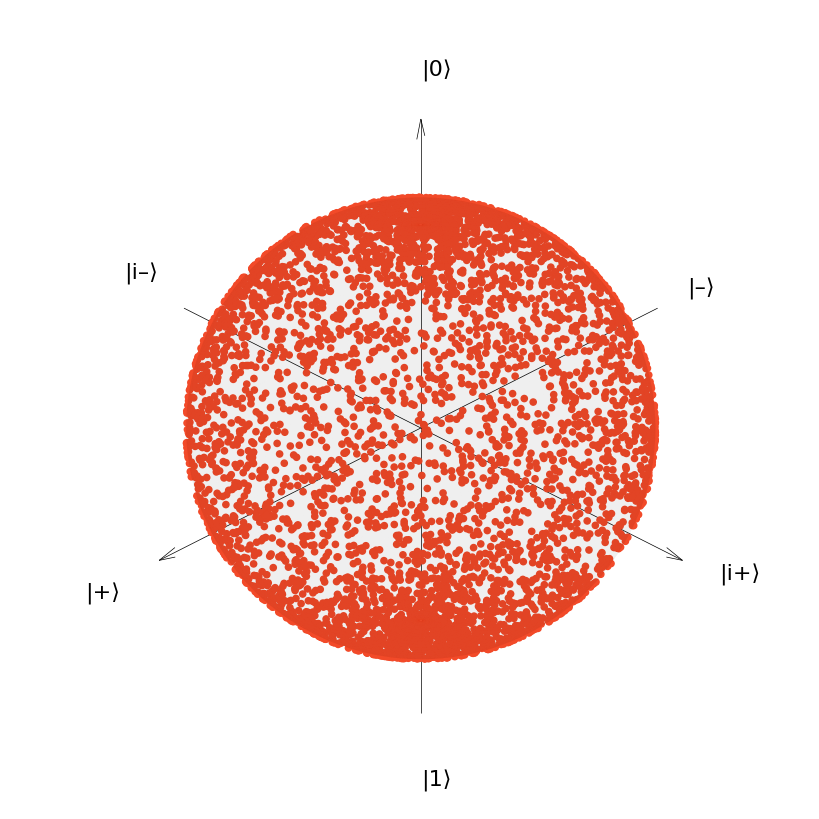

In [28]:
plot_state_in_bloch_sphere(outputs_zyz, save_gif=True, filename='figures/bloch_zyz.gif')

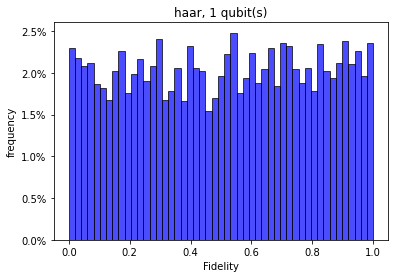

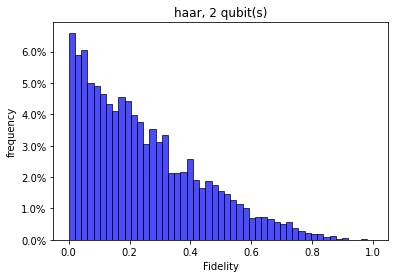

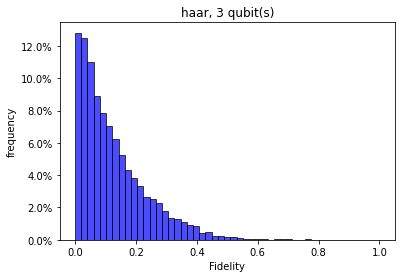

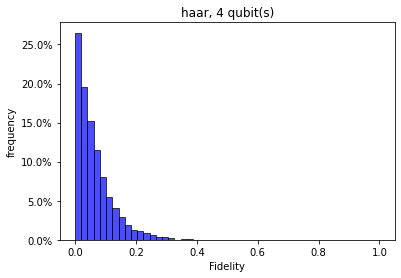

In [29]:
from paddle_quantum.linalg import haar_unitary
from paddle_quantum.qinfo import state_fidelity
from paddle_quantum.state.common import to_state
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import integrate

# plot histgram
def plot_hist(data, num_bin, title_str):
    def to_percent(y, position):
        return str(np.around(y*100, decimals=2)) + '%'
    plt.hist(data, weights=[1./len(data)]*len(data), bins=np.linspace(0, 1, num=num_bin), facecolor="blue", edgecolor="black", alpha=0.7)
    plt.xlabel("Fidelity")
    plt.ylabel("frequency")
    plt.title(title_str)
    formatter = FuncFormatter(to_percent)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.show()
    
    
# evaluate the probability distribution of F generated by a Haar random unitary
def p_F_haar(n, s, b=50, draw=False):
    f_list = list()
    # sampling
    for i in range(s):
        # sample a unitary
        u1 = haar_unitary(n)
        # the output of u1
        phi1 = u1[:,0].numpy()
        # sample a unitary
        u2 = haar_unitary(n)
        phi2 = u2[:,0].numpy()
        # the output of u2
        # rho2 = to_state(np.outer(phi2, phi2.conj()))
        # compute fidality
        f_list.append(qi.state_fidelity(phi1, phi2))
    f_list = np.array(f_list)

    # plot histgram
    if draw:
        title_str = "haar, %d qubit(s)" % num_qubit
        plot_hist(f_list, b, title_str)
    sample_distribution, _ = np.histogram(f_list, bins=np.linspace(0, 1, num=b), density=True)

    # compute a theoretical distribution
    theory_distribution = np.zeros_like(sample_distribution)
    for index in range(len(theory_distribution)):
        def p_continues(f):
            return (2 ** n - 1) * (1 - f) ** (2 ** n - 2)
        lower = 1/b*index
        upper = lower + 1/b
        theory_distribution[index], _ = integrate.quad(p_continues,lower,upper)
    return sample_distribution, theory_distribution


num_qubit = 1
p_haar_1qubit, theory_haar_1qubit = p_F_haar(num_qubit, num_sample, draw=True)
num_qubit = 2
p_haar_2qubit, theory_haar_2qubit = p_F_haar(num_qubit, num_sample, draw=True)
num_qubit = 3
p_haar_3qubit, theory_haar_3qubit = p_F_haar(num_qubit, num_sample, draw=True)
num_qubit = 4
p_haar_4qubit, theory_haar_4qubit = p_F_haar(num_qubit, num_sample, draw=True)

/usr/local/lib/python3.9/dist-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.bool:


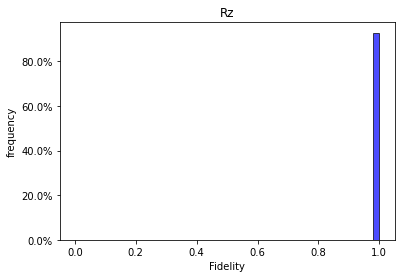

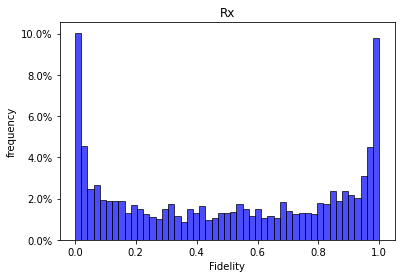

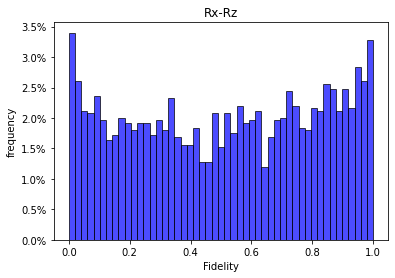

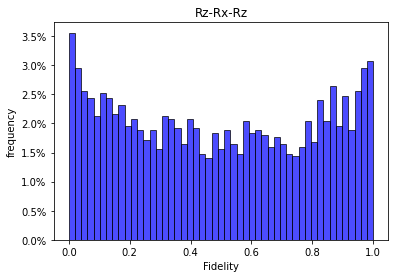

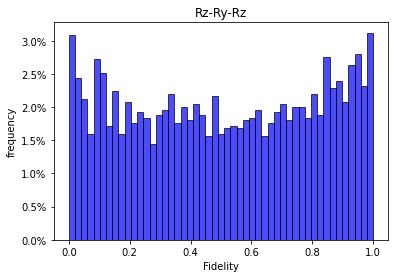

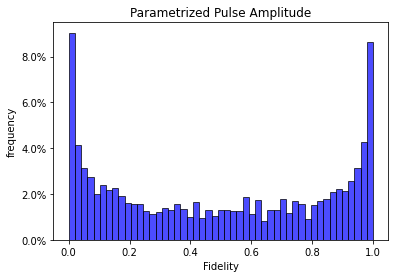

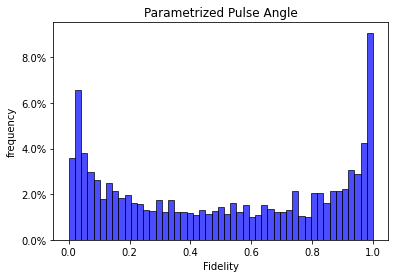

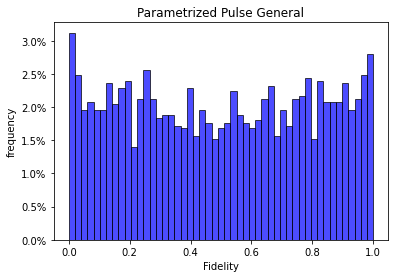

In [30]:
# evaluate the probability distribution of F generated by QNNs
def p_F_qnn(n, s, g, b=50, draw=False):
    f_list = list()
    rho_sample = outputs_z
    title_str = "Rz"
    if g == 2:
        rho_sample = outputs_x
        title_str = "Rx"
    elif g == 3:
        rho_sample = outputs_xz
        title_str = "Rx-Rz"
    elif g == 4:
        rho_sample = outputs_zxz
        title_str = "Rz-Rx-Rz"
    elif g == 5:
        rho_sample = outputs_zyz
        title_str = "Rz-Ry-Rz"
    elif g == 6:
        rho_sample = outputs_amp
        title_str = "Parametrized Pulse Amplitude"
    elif g == 7:
        rho_sample = outputs_angle
        title_str = "Parametrized Pulse Angle"
    elif g == 8:
        rho_sample = outputs_mix
        title_str = "Parametrized Pulse General"

    # use previously collected data to compute fidelity
    for index in range(int(s / 2)):
        rho1 = rho_sample[index]
        rho2 = rho_sample[index+int(num_sample / 2)]
        f_list.append(state_fidelity(rho1, rho2)**2)
    f_list = np.array(f_list)
    
    # plot histgram
    if draw:
        plot_hist(f_list, b, title_str)
    distribution, _ = np.histogram(f_list, bins=np.linspace(0, 1, num=b), density=True)
    return distribution
    
    
num_qubit = 1
p_z = p_F_qnn(num_qubit, num_sample, 1, draw=True)
p_x = p_F_qnn(num_qubit, num_sample, 2, draw=True)
p_xz = p_F_qnn(num_qubit, num_sample, 3, draw=True)
p_zxz = p_F_qnn(num_qubit, num_sample, 4, draw=True)
p_zyz = p_F_qnn(num_qubit, num_sample, 5, draw=True)
p_amp = p_F_qnn(num_qubit, num_sample, 6, draw=True)
p_ang = p_F_qnn(num_qubit, num_sample, 7, draw=True)
p_pulse = p_F_qnn(num_qubit, num_sample, 8, draw=True)

In [31]:
from scipy.stats import entropy
# calcutale relative entropy (K-L divergence)
expr_z = entropy(p_z, theory_haar_1qubit)
expr_x = entropy(p_x, theory_haar_1qubit)
expr_xz = entropy(p_xz, theory_haar_1qubit)
expr_zxz = entropy(p_zxz, theory_haar_1qubit)
expr_zyz = entropy(p_zyz, theory_haar_1qubit)
expr_amp = entropy(p_amp, theory_haar_1qubit)
expr_ang = entropy(p_ang, theory_haar_1qubit)
expr_pulse = entropy(p_pulse, theory_haar_1qubit)
print("The expressiblity of Rz, Rx-Rz, RZ-RX-RZ, Rz-Ry-Rz, amp, angle, and Parametrized Pulse are %.2f, %.2f, %.2f,%.2f, %.2f, %.2f and %.2f, respectively." %(expr_z, expr_xz, expr_zxz, expr_zyz,expr_amp,expr_ang, expr_pulse))

The expressiblity of Rz, Rx-Rz, RZ-RX-RZ, Rz-Ry-Rz, amp, angle, and Parametrized Pulse are 3.89, 0.02, 0.02,0.02, 0.20, 0.17 and 0.01, respectively.


In [32]:
expr_zyz

0.01739511565043379

In [33]:
expr_pulse

0.01385036174130507

In [34]:
expr_x

0.2344808886460163

In [35]:
expr_z

3.8918202981106265

In [36]:
expr_xz

0.022257547686168104

In [38]:
expr_zxz

0.024612009526576703

In [39]:
expr_amp

0.19857216826804813

In [40]:
expr_ang

0.17098612152110412

## Quito 5-qubits Results Summary

| operation | K-L divergence (lower=better)|
|:---------:|:----------------------------:|
|   Rz        | 3.8918202981106265 |
|   Rx        | 0.22423530021602292 |
|   Rx-Rz        | 0.055125782012239354 |
|   Rz-Rx-Rz        | 0.06567693464879201 |
|   **Rz-Ry-Rz $\approx$ U3**        | **0.07266000086957257** |
|   **Rz-Ry-Rz (num_sample=5000)**        | **0.02209921853350049** |
|   Parametrized Amp, angle =0        | 0.219721086010916 |
|   Amp = 0.5, Parametrized Angle        | 0.23501008849057425 |
|   **Parametrized Pulse 1-qubit amp=[0,1]**   | **0.049482493376160695** |
|   **Parametrized Pulse 1-qubit amp=[0,0.4]**  | **0.051138933718577494** |

## Process Tomography

# Multi-qubit case